# Project Writeup
### 1. A discussion of your exploration of the dataset
My exploration of the data was pretty simple. I looked at the histrogram of all the ratings to get a sense for the general spread. By looking at the histogram, I saw that the ratings resemble a simple normal distribution with a mean around 3.5 and a pretty low variance. In addition to looking at the histrogram, I also printed out the first and last dozen rows (approximately) in order to see what kind of features I was working with. I knew I was going to want to include some information about movies in my model without just using the id because that would be useless. So I looked into getting information about each movie. I paid particular attention to the genres of each movie. I was surprised to find that there were only 20 genres for all hundreds of thousands. I also saw the tags. Since there were hundreds of tags compared to the 20 genres, I decided it would be simpler and easier to work with genres when comparing movies rather than tags.

### 2. A clear technical description of your approach
I decided early on that I would use an MLP to try to solve this problem. I did this for three reasons. First and foremost, I see ratings as a regression problem, which MLP do well on. Second, I understand MLP better than most other machine learning concepts. And third, I knew that I could use the Keras library to do the real technical heavy lifting for me so that I could focus more on the concepts.

Although my goal was to use an MLP, I started by performing the most simple prediction in order to have a baseline to work from. This naive prediction algorithm was to simply assign every user/movie pair the mean score of all ratings in my training set. This naive approach did surprisingly well with an RMSE as low as 0.998.

After I had this naive baseline, I began to plan my MLP model. Before spending too much time working on complicated inputs features for the MLP, I decided to try the most basic inputs possible: the mean rating the user in question gave to movies and the mean rating the movie in question had received. With only these two features as inputs, I decided my first MLP could simply be a perceptron with 2 inputs and 1 output. The perceptron would essentially be trying to find the best way to combine a user's mean rating given and movie's mean rating received in order to predict the rating that user would give that movie. This basic perceptron also did surprising well with an RMSE as low as 0.824 on my testing data.

I was very surprised that my simple perceptron was able to achieve this accuracy. Based on my knowledge of other students' results, I was satisfied with my results and decided to end my experiments and not pursue a more complicated MLP predictor. This was largely a factor of time. Since I am already late, I decided it was more important for me to turn in what I had done than spend more time experimenting.

However, I had put a lot of thought into the feature space I would use for an MLP. I wanted to include in the input space a vector of 20 numbers (0, 1) to represent the genres the movie belonged in. I would then include another vector of 20 numbers that would be the mean rating the user gave to movies from each genre. For any genre that a user hadn't rated, I would have set the value to the mean rating value fromt he entire training set. By using these two genre vectors (one for the movie and one for the user) I hoped to capture unough information about both to allow the MLP to find patterns necessary for predicting a user's rating of a movie.

As a final note for this section, to separate my data into training and testing sets I just used the code provided in the hints section of the spec that made a random subset of 85,000 values from the training data to be the test set. The remaining values served as my true training values.

### 3. An analysis of how your approach worked on the dataset
As stated above, the final RMSE on my test set was 0.824.

I do not believe that I overfit the data because my RMSE on my test and validation sets (0.830 and 0.824, respectively) was significantly lower than the RMSE on my training set (0.928).

I ended up not using the first algorithm I had originally planned on using (the more robust MLP). Instead, I tried starting with simpler solutions and found that they were quite effective dispite their simplicity. I decided to apply Occham's Razor and assume that a simpler model that performs well is preferable to a larger model.

In [1]:
import numpy as np
import arff
import random
import math
import keras
from keras.layers.core import Dense, Activation
from keras.models import Sequential
import kjr_tools
import pandas
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.
/Users/kevinjreece/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def measurePredictions(predictions, targets):
    sse = 0
    for i, (index, t) in enumerate(targets.iterrows()):
        sse += (t.rating - predictions[i]) ** 2
    mse = sse / len(targets)
    rmse = math.sqrt(mse)
    return rmse

In [3]:
ur = pandas.read_csv('data/movie_training_data/user_ratedmovies_train.dat','\t')
predictions = pandas.read_csv('data/predictions.dat','\t')
movie_actors = pandas.read_csv('data/movie_training_data/movie_actors.dat', '\t')
movie_genres = pandas.read_csv('data/movie_training_data/movie_genres.dat', '\t')
movie_tags = pandas.read_csv('data/movie_training_data/movie_tags.dat', '\t')
movies = pandas.read_csv('data/movie_training_data/movies.dat', '\t')
tags = pandas.read_csv('data/movie_training_data/tags.dat', '\t')
user_tags = pandas.read_csv('data/movie_training_data/user_taggedmovies.dat', '\t')

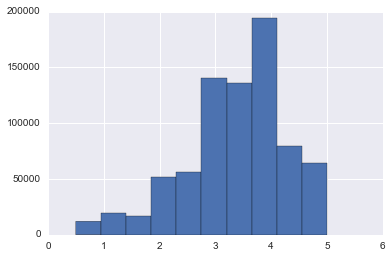

In [4]:
plt.hist( ur['rating'] )
 
# create a test/train split
 
all_inds = np.random.permutation( range(0,len(ur)) )
test_inds = all_inds[0:85000]
train_inds = all_inds[85000:len(ur)]
 
ur_test = ur.iloc[ test_inds ]
ur_train = ur.iloc[ train_inds ]

all_train_inds = np.random.permutation(range(0, len(ur_train)))
validation_inds = all_train_inds[0:150000]
learn_inds = all_train_inds[150000: len(ur_train)]

ur_validation = ur_train.iloc[validation_inds]
ur_learn = ur_train.iloc[learn_inds]

In [5]:
num_movies = movies.iloc[-1]['id'] + 1
genres_set = set(movie_genres['genre'])
num_genres = len(genres_set)
num_users = max(ur_train.userID) + 1

genres_dict = {}
for i, g in enumerate(genres_set):
    genres_dict[g] = i
movie_genre_vectors = np.zeros((num_movies, num_genres))
for index, row in movie_genres.iterrows():
    movie_genre_vectors[row['movieID']-1, genres_dict[row['genre']]] += 1

In [ ]:
#####
# Naive solution
#####
train_ratings = ur_train.rating
train_mean = np.mean(train_ratings)
naive_predictions = [train_mean] * len(ur_test)

print measurePredictions(naive_predictions, ur_test)

In [6]:
# average rating each user gave in the training dataset
user_mean_ratings = np.array([np.mean(ur_train[ur_train.userID == user_id].rating) \
                              for user_id in range(num_users)])
# average rating each movie received in the training dataset
movie_mean_ratings = np.array([np.mean(ur_train[ur_train.movieID == movie_id].rating) \
                               for movie_id in range(num_movies)])

In [7]:
user_mean_ratings[np.isnan(user_mean_ratings)] = np.mean(ur_learn.rating)
movie_mean_ratings[np.isnan(movie_mean_ratings)] = np.mean(ur_learn.rating)

In [8]:
ur_learn_targets = ur_learn[['rating']].values
ur_validation_targets = ur_validation[['rating']].values
ur_train_targets = ur_train[['rating']].values
ur_test_targets = ur_test[['rating']].values

In [17]:
# learn
user_mean_per_learn_input = np.atleast_2d([user_mean_ratings[user_id] \
                                           for user_id in ur_learn.userID.values]).T
movie_mean_per_learn_input = np.atleast_2d([movie_mean_ratings[movie_id] \
                                            for movie_id in ur_learn.movieID.values]).T
ur_learn_inputs = np.concatenate((user_mean_per_learn_input, movie_mean_per_learn_input), axis=1)

# validation
user_mean_per_validation_input = np.atleast_2d([user_mean_ratings[user_id] \
                                                for user_id in ur_validation.userID.values]).T
movie_mean_per_validation_input = np.atleast_2d([movie_mean_ratings[movie_id] \
                                                 for movie_id in ur_validation.movieID.values]).T
ur_validation_inputs = np.concatenate((user_mean_per_validation_input, movie_mean_per_validation_input), axis=1)

# train
user_mean_per_train_input = np.atleast_2d([user_mean_ratings[user_id] \
                                                for user_id in ur_train.userID.values]).T
movie_mean_per_train_input = np.atleast_2d([movie_mean_ratings[movie_id] \
                                                 for movie_id in ur_train.movieID.values]).T
ur_train_inputs = np.concatenate((user_mean_per_train_input, movie_mean_per_train_input), axis=1)

# test
user_mean_per_test_input = np.atleast_2d([user_mean_ratings[user_id] \
                                                for user_id in ur_test.userID.values]).T
movie_mean_per_test_input = np.atleast_2d([movie_mean_ratings[movie_id] \
                                                 for movie_id in ur_test.movieID.values]).T
ur_test_inputs = np.concatenate((user_mean_per_test_input, movie_mean_per_test_input), axis=1)

# predictions
user_mean_per_prediction_input = np.atleast_2d([user_mean_ratings[user_id] \
                                           for user_id in predictions.userID.values]).T
movie_mean_per_prediction_input = np.atleast_2d([movie_mean_ratings[movie_id] \
                                            for movie_id in predictions.movieID.values]).T
prediction_inputs = np.concatenate((user_mean_per_prediction_input, movie_mean_per_prediction_input), axis=1)

In [10]:
#####
# Basic perceptron
#####
perceptron_model = Sequential()
perceptron_model.add(Dense(1, input_dim=2))
perceptron_model.compile(loss='mse', optimizer='sgd')

In [11]:
perceptron_model.fit(ur_train_inputs[:10000], ur_train_targets[:10000],
          nb_epoch=2,
          batch_size=1,
          show_accuracy=True)

Epoch 1/2
10000/10000 [==============================] - 7s - loss: 0.8882 - acc: 0.2575     
Epoch 2/2
10000/10000 [==============================] - 7s - loss: 0.8620 - acc: 0.2642     


In [12]:
perceptron_score_validation = perceptron_model.evaluate(ur_validation_inputs, ur_validation_targets, batch_size=5)

150000/150000 [==============================] - 14s    


In [13]:
perceptron_score_test = perceptron_model.evaluate(ur_test_inputs, ur_test_targets, batch_size=5)

85000/85000 [==============================] - 9s     


In [15]:
print perceptron_score_validation

0.688463765789


In [16]:
print perceptron_score_test

0.679243177927


In [25]:
final_predictions = np.array([perceptron_model.predict(np.atleast_2d(i)) for i in prediction_inputs])

In [31]:
final_predictions[final_predictions > 5] = 5

In [34]:
f = open('reece_predictions.txt', 'w')
for i, p in enumerate(final_predictions):
    f.write("{},{}\n".format(i, p[0, 0]))
f.close()

# Code I started for the complicated MLP but never used

In [ ]:
user_genre_matrix = []
for i in range(num_users):
    user_genre_matrix.append([])
    
for i, row in ur_train.iterrows():
    user_id = int(row.userID)
    movie_id = int(row.movieID)
    rating = row.rating
    movie_genre_vector = movie_genre_vectors[movie_id] * rating
    user_genre_matrix[user_id].append(movie_genre_vector)
    
user_genre_matrix = np.array(map(np.array, user_genre_matrix))